In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from ensemble_boxes import ensemble_boxes_wbf
import glob
from xml.etree import ElementTree as ET
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from model import EffcientDetModel

# Load model & prepare loader

In [2]:
model = EffcientDetModel(
    task='predict', model_architecture='tf_efficientnetv2_l'
)

Global seed set to 142


In [3]:
model.load_state_dict(torch.load('weights/effdet_fruits_l.pth'))
model.to('cuda')
model.eval();

In [4]:
gts = glob.glob('data/archive/test_zip/test/*.xml')

In [5]:
transforms = A.Compose(
    [
        A.Resize(height=512, width=512, p=1),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(p=1)
    ]
)

In [6]:
labels = {
    'orange': 0,
    'banana': 1,
    'apple': 2
}

index_labels = {
    0: 'orange',
    1: 'banana',
    2: 'apple'
}

# Prepare data

In [7]:
selected_gt = np.random.choice(gts)

In [8]:
root = ET.parse(selected_gt)

In [9]:
image_name = root.find('filename').text
image_path = glob.glob(os.path.join('data/archive/test_zip/test/', image_name))[0]
img = cv2.imread(image_path)

In [10]:
labelled_data = []
for obj in root.findall('object'):
    tmp_data = []
    tmp_data.append(labels[obj.find('name').text])
    for bb in obj.find('bndbox'):
        tmp_data.append(int(bb.text))
        
    labelled_data.append(tmp_data)
    
labelled_data = np.array(labelled_data)

In [11]:
sample = transforms(image=img)

In [12]:
img_tensor = sample['image'].unsqueeze(0).cuda()

In [13]:
outputs = model.model(img_tensor)

# Post processing

In [14]:
pred_boxes = outputs[0].detach().cpu().numpy()[:, :4]
pred_scores = outputs[0].detach().cpu().numpy()[:, 4]
pred_classes = outputs[0].detach().cpu().numpy()[:, 5]
indexes = np.where(pred_scores > 0.2)[0]
pred_boxes = pred_boxes[indexes]
pred_scores = pred_scores[indexes]
pred_classes = pred_classes[indexes]

In [15]:
bboxes = [(pred_boxes / 512).tolist()]
confidences = [pred_scores.tolist()]
class_labels = [pred_classes.tolist()]

boxes, scores, label = ensemble_boxes_wbf.weighted_boxes_fusion(
    bboxes, confidences, class_labels, 
    weights=None, iou_thr=0.5, skip_box_thr=0.0001
)

boxes = boxes * (512 - 1)

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:64: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')


In [16]:
scaled_bboxes = np.array(boxes) * [
    img.shape[1] / 512,
    img.shape[0] / 512,
    img.shape[1] / 512,
    img.shape[0] / 512,
]

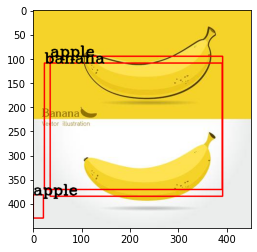

In [17]:
img = cv2.imread(image_path)
for i, box in enumerate(scaled_bboxes):
    box = box.astype(np.int)
    cv2.rectangle(
        img,
        (box[0], box[1]),
        (box[2], box[3]),
        (0, 0, 255), 2
    )
    cv2.putText(
        img, index_labels[label[i]], (box[0], box[1]), 
        cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2
    )

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))